In [174]:
from functools import partial

from astropy.coordinates import cartesian_to_spherical
from matplotlib import ticker

from common.conics import plot_conics, ConicProjector, ellipse_axes, scale_det, conic_center, ellipse_angle, \
    conic_matrix, MaskGenerator
from common.coordinates import ENU_system
from src import CraterDetector
from src.matching import CraterDatabase, CoplanarInvariants
from src.common.data import DataGenerator
from src.detection.metrics import gaussian_angle_distance
import src.common.constants as const
import numpy as np
import numpy.linalg as LA
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor
from scipy.stats import median_absolute_deviation
from scipy.optimize import least_squares, minimize
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist

import torch
import matplotlib.pyplot as plt

In [39]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv",
                              latlims=(0, 30),
                              longlims=(0, 30),
                              diamlims=(4, 40)
                              )

In [40]:
gen = MaskGenerator.from_robbins_dataset(file_path="../data/lunar_crater_database_robbins_2018.csv", diamlims=(4, 40), axis_threshold=(1, 250))
gen.set_coordinates(10, 10, 250, convert_to_radians=True)

In [41]:
sigma_pix = 2
A_craters = gen.craters_in_image()

n_det = len(A_craters)
# Add noise
major_det, minor_det = ellipse_axes(A_craters)
psi_det = ellipse_angle(A_craters)
r_craters_det = conic_center(A_craters)

major_det += np.random.uniform(-sigma_pix, sigma_pix, size=n_det)
minor_det += np.random.uniform(-sigma_pix, sigma_pix, size=n_det)
psi_det += np.random.normal(scale=(20/180)*np.pi, size=n_det)
r_craters_det += np.random.normal(-sigma_pix, sigma_pix, size=r_craters_det.shape)

A_detections = conic_matrix(major_det, minor_det, psi_det, *r_craters_det.T)

In [94]:
C_cat, r_cat = gen.visible_catalogue_craters()

A_query, r_query, C_query = db.query(A_detections, k=10, max_distance=0.05, batch_size=1000)
A_query.shape, r_query.shape, C_query.shape

((24, 3, 3), (24, 3, 1), (24, 3, 3))

In [95]:
k = np.array([0., 0., 1.])[:, None]
S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)

T = gen.T
K = gen.K

B_craters = T @ K.T @ A_query @ K @ LA.inv(T)
T_EM = np.concatenate(ENU_system(r_query), axis=-1)
T_ME = LA.inv(T_EM)

A_ = S.T @ T_ME @ B_craters
A = A_.reshape(-1, 3)
b_ = S.T @ T_ME @ B_craters @ r_query
b = b_.reshape(-1, 1)

In [96]:
def _model_validator(min_alt=10, max_alt=1000, primary_body_radius=const.RMOON):
    return lambda model, *args: (primary_body_radius + min_alt) < LA.norm(model.coef_) < (primary_body_radius + max_alt)

degraded_position = gen.position + np.random.randn(3, 1)*100

ransac = RANSACRegressor(residual_threshold=0.05, max_trials=10000, is_model_valid=_model_validator())
ransac.fit(A/np.mean(b), b/np.mean(b))
inlier_mask = np.logical_and.reduce(ransac.inlier_mask_.reshape(b_.shape), axis=(-1, -2))
num_inliers = inlier_mask.sum()

est_pos_lsq, _, _, _ = LA.lstsq(A/1e6, b/1e6)

est_pos_ransac = ransac.estimator_.coef_.T
print(f"Least squares:\tPosition error: {LA.norm(est_pos_lsq - gen.position):.2f} km")
print(f"RANSAC:\t\tPosition error: {LA.norm(est_pos_ransac - gen.position):.2f} km | Inliers: {num_inliers}")

Least squares:	Position error: 91.06 km
RANSAC:		Position error: 3.10 km | Inliers: 12


C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


In [73]:
C_inlier, r_inlier = C_query.reshape(-1, 3, 3)[inlier_mask], r_query.reshape(-1, 3, 1)[inlier_mask]

projector = ConicProjector(position=est_pos_ransac, attitude=gen.T)

A_projected = projector.project_crater_conics(C_inlier, r_inlier)
A_matched = A_query[inlier_mask]

In [74]:
sigma_pix = 5

divergence = gaussian_angle_distance(A_projected, A_matched)

a_i, b_i = ellipse_axes(A_projected)

sigma = (0.85 / np.sqrt(a_i * b_i)) * sigma_pix

reprojection_mask = ((divergence / sigma) ** 2) <= 13.276
A_verified = A_matched[reprojection_mask]
r_verified = r_query[inlier_mask][reprojection_mask]

In [75]:
B_verified = T @ K.T @ A_verified @ K @ LA.inv(T)
T_EM = np.concatenate(ENU_system(r_verified), axis=-1)
T_ME = LA.inv(T_EM)

A_ = S.T @ T_ME @ B_verified
A = A_.reshape(-1, 3)
b_ = S.T @ T_ME @ B_verified @ r_verified
b = b_.reshape(-1, 1)

In [76]:
from scipy.optimize import curve_fit
est_pos_verified = least_squares(
    lambda x: (b - A @ x[:, None]).squeeze(),
    x0=ransac.estimator_.coef_.squeeze()
)

LA.norm(est_pos_verified.x[:, None] - gen.position)

295.2793380994986

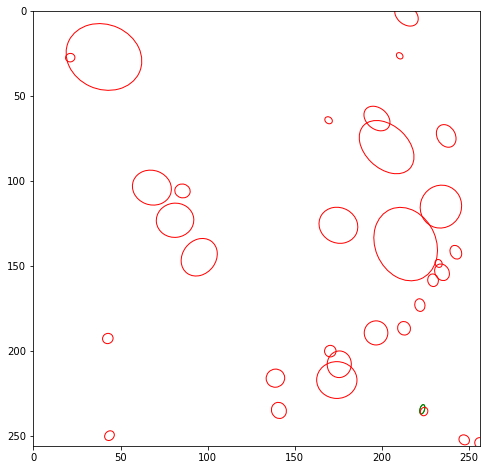

In [77]:
fig, axes = plt.subplots(figsize=(8, 8))
plot_conics(A_verified, ax=axes, rim_color='green')
plot_conics(A_craters, ax=axes)
# plot_conics(A_craters, ax=axes, rim_color='cyan')
# plot_conics(A_projected, ax=axes, rim_color='purple')

In [133]:
from src.matching.position_estimation import PositionRegressor
position_regressor = PositionRegressor(residual_threshold=0.1)


In [161]:
np.seterr("ignore")
test_size = 50000

attitude_test = np.empty((test_size, 3, 3), np.float64)
true_position_test = np.full((test_size, 3, 1), np.nan, np.float64)
pred_ransac_test = np.full((test_size, 3, 1), np.nan, np.float64)
pred_reprojection_test = np.full((test_size, 3, 1), np.nan, np.float64)
n_detections_test = np.zeros((test_size))
n_inliners_test = np.zeros((test_size))
n_verified_test = np.zeros((test_size))

sigma_pix = 2

matches = 0
errors = 0
for i in range(test_size):
    n_det = 0
    while n_det < 6:
        gen.set_coordinates(np.random.uniform(5, 25), np.random.uniform(5, 25))
        gen.height = np.random.uniform(50, 200)
        gen.point_nadir()
        gen.rotate('roll', np.random.uniform(0, 360))
        gen.rotate('pitch', np.random.uniform(-10, 10))
        gen.rotate('yaw', np.random.uniform(-10, 10))
        A_craters = gen.craters_in_image()
        n_det = len(A_craters)

    attitude_test[i] = gen.attitude
    true_position_test[i] = gen.position

    n_detections_test[i] = n_det
    # Add noise
    major_det, minor_det = ellipse_axes(A_craters)
    psi_det = ellipse_angle(A_craters)
    r_craters_det = conic_center(A_craters)

    major_det += np.random.normal(0, sigma_pix, size=n_det)
    minor_det += np.random.normal(0, sigma_pix, size=n_det)
    psi_det += np.random.normal(scale=(20/180)*np.pi, size=n_det)
    r_craters_det += np.random.normal(0, sigma_pix, size=r_craters_det.shape)

    A_detections = conic_matrix(major_det, minor_det, psi_det, *r_craters_det.T)
    try:
        position_regressor = db.query_position(A_detections, T=gen.T, K=gen.K,
                                               sigma_pix=4,
                                               k=30, max_distance=0.05, batch_size=1000,
                                               residual_threshold=0.05, max_trials=2000)
        if position_regressor.ransac_match():
            pred_ransac_test[i] = position_regressor.est_pos_ransac
            n_inliners_test[i] = position_regressor.num_inliers
            print(f"[{i:05}]\tRANSAC position error: {LA.norm(position_regressor.est_pos_ransac - gen.position):9.2f} km\t"
                  f"| Inliers: {position_regressor.num_inliers}", end= "\t")

            if position_regressor.reprojection_match():
                pred_reprojection_test[i] = position_regressor.est_pos_verified
                n_verified_test[i] = position_regressor.num_verified
                print(f"Verified position error:  {LA.norm(position_regressor.est_pos_verified - gen.position):9.2f} km", end="")

            print()
            matches += 1
    except ValueError:
        pass

matches

[00000]	RANSAC position error:    187.66 km	| Inliers: 6	Verified position error:  2497293.14 km
[00002]	RANSAC position error:      1.90 km	| Inliers: 9	Verified position error:       1.60 km
[00005]	RANSAC position error:    211.27 km	| Inliers: 3	
[00006]	RANSAC position error:      4.82 km	| Inliers: 12	Verified position error:       4.40 km
[00015]	RANSAC position error:     23.29 km	| Inliers: 6	
[00018]	RANSAC position error:    280.52 km	| Inliers: 4	
[00019]	RANSAC position error:    204.60 km	| Inliers: 4	
[00021]	RANSAC position error:      2.98 km	| Inliers: 11	Verified position error:      78.36 km
[00026]	RANSAC position error:    224.67 km	| Inliers: 5	
[00028]	RANSAC position error:      1.70 km	| Inliers: 22	Verified position error:       4.29 km
[00030]	RANSAC position error:     19.33 km	| Inliers: 6	
[00032]	RANSAC position error:      3.99 km	| Inliers: 13	Verified position error:       4.17 km
[00034]	RANSAC position error:      3.97 km	| Inliers: 12	Verified posi

ValueError: RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).

(14618, 6568)

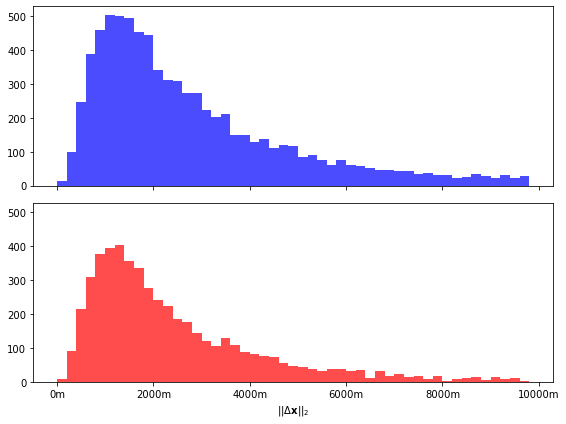

In [162]:
inlier_positions = np.logical_and.reduce(~np.isnan(pred_ransac_test), axis=(1,2))
err_inliers = LA.norm(pred_ransac_test[inlier_positions] - true_position_test[inlier_positions], axis=1).ravel()*1000
verified_positions = np.logical_and.reduce(~np.isnan(pred_reprojection_test), axis=(1,2))
err_verified = LA.norm(pred_reprojection_test[verified_positions] - true_position_test[verified_positions], axis=1).ravel()*1000
bins = np.arange(0, 10000, 200)
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex='all', sharey='all')

axes[0].hist(err_inliers, bins=bins, color='blue', alpha=0.7)
axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))

axes[1].hist(err_verified, bins=bins, color='red', alpha=0.7)
axes[1].set_xlabel("$||\Delta \mathbf{x}||_2$")
axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))

fig.tight_layout()
fig.savefig("../output/total_error.pdf")
len(err_inliers), len(err_verified)

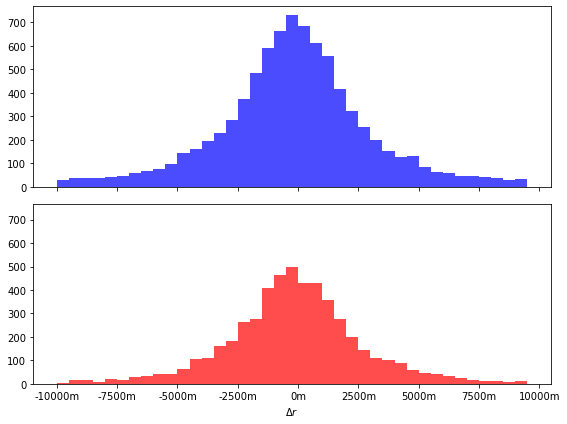

In [163]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex='all', sharey='all')


for pred, true, color, ax in zip([pred_ransac_test[inlier_positions], pred_reprojection_test[verified_positions]],
                            [true_position_test[inlier_positions], true_position_test[verified_positions]],
                           ["blue", 'red'], axes):
    err_r, err_lat_rad, err_lon_rad = np.array(cartesian_to_spherical(*pred.squeeze().T) -
                                               np.array(cartesian_to_spherical(*true.squeeze().T)))

    err_lat, err_lon = map(np.degrees, (err_lat_rad, err_lon_rad))

    err_lon[err_lon > 180] -= 360


    ax.hist(err_r*1000, bins=np.arange(-10000, 10000, 500), color=color, alpha=0.7)
axes[1].set_xlabel(r'$\Delta r$')
axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))
fig.tight_layout()
fig.savefig("../output/radial_error.pdf")

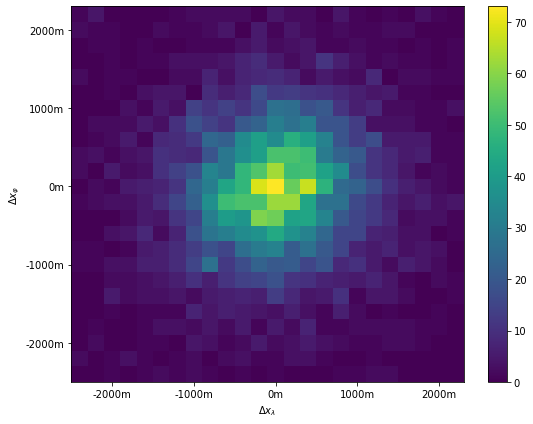

In [164]:
err_r, err_lat_rad, err_lon_rad = np.array(cartesian_to_spherical(*(pred).squeeze().T) -
                                           np.array(cartesian_to_spherical(*(true).squeeze().T)))

err_lat, err_lon = map(np.degrees, (err_lat_rad, err_lon_rad))
fig, ax = plt.subplots(figsize=(8, 6))
err_range = np.arange(-2500, 2500, 200)
h = ax.hist2d(LA.norm(true_position_test[verified_positions], axis=(1,2)) * err_lon_rad * 1e3,
              LA.norm(true_position_test[verified_positions], axis=(1,2)) * err_lat_rad * 1e3,
              bins=err_range, cmap='viridis')
ax.set_xlabel(r'$\Delta x_{\lambda}$')
ax.set_ylabel(r'$\Delta x_{\varphi}$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
plt.colorbar(h[3], ax=ax)
fig.tight_layout()
fig.savefig("../output/coordinate_error.pdf")

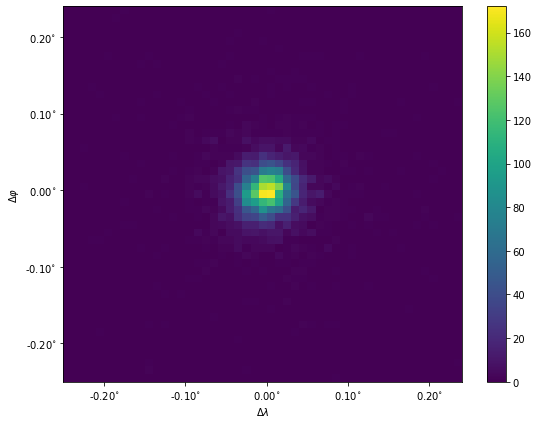

In [165]:
fig, ax = plt.subplots(figsize=(8, 6))
err_range = np.arange(-0.25, 0.25, 0.01)
h = ax.hist2d(err_lon, err_lat, bins=err_range, cmap='viridis')
ax.set_xlabel(r'$\Delta \lambda$')
ax.set_ylabel(r'$\Delta \varphi$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f$^{\circ}$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f$^{\circ}$'))
plt.colorbar(h[3], ax=ax)
fig.tight_layout()
fig.savefig("../output/coordinate_error_degrees.pdf")

19951872.380152795

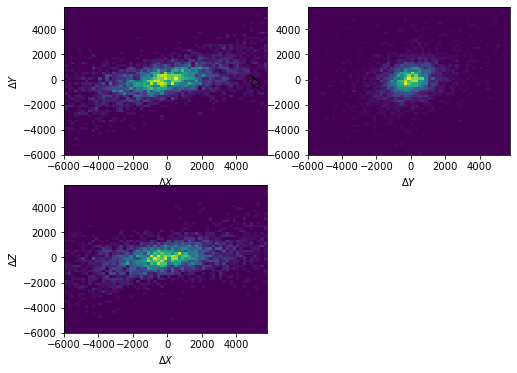

In [166]:
err_x, err_y, err_z = ((pred_reprojection_test[verified_positions] - true_position_test[verified_positions])*1000).squeeze().T
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

err_range = np.arange(-6000, 6000, 200)

h = ax[0, 0].hist2d(err_x, err_y, bins=err_range, cmap='viridis')
ax[0, 0].set_xlabel('$\Delta X$')
ax[0, 0].set_ylabel('$\Delta Y$')

ax[1, 0].hist2d(err_x, err_z, bins=err_range, cmap='viridis')
ax[1, 0].set_xlabel('$\Delta X$')
ax[1, 0].set_ylabel('$\Delta Z$')

ax[0, 1].hist2d(err_y, err_z, bins=err_range, cmap='viridis')
ax[0, 1].set_xlabel('$\Delta Y$')
ax[0, 1].set_ylabel('$\Delta Z$')

ax[1, 1].axis('off')
# plt.colorbar(h[3], ax=ax[1, 1])
np.nanmean(err_x)

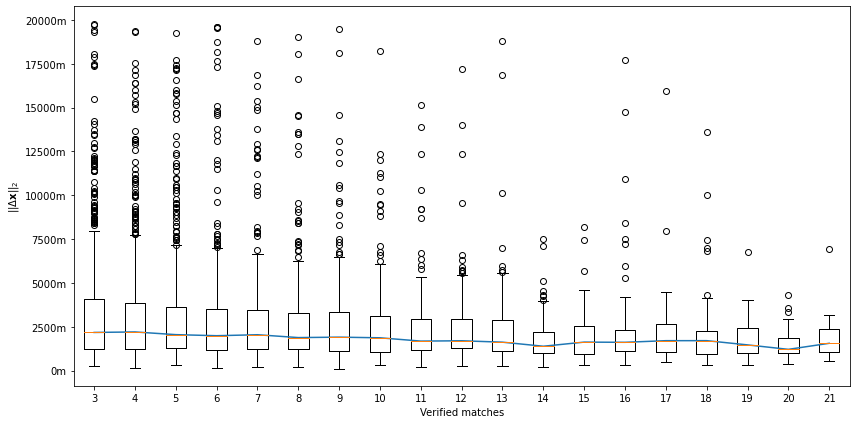

In [167]:
dist_filter = err_verified < 20e3
fig, ax = plt.subplots(figsize=(12, 6))
n = n_verified_test[verified_positions][dist_filter]
e = err_verified[dist_filter]
data = []
ticklabels = []
medians = []
for i, c in zip(*np.unique(n_verified_test, return_counts=True)):
    if c < 30 or i <= 2:
        continue
    data.append(e[n == i])
    ticklabels.append(int(i))
    medians.append(np.median(e[n == i]))

ax.boxplot(data, positions=ticklabels)
ax.plot(ticklabels, medians)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
ax.set_xlabel("Verified matches")
ax.set_ylabel("$||\Delta \mathbf{x}||_2$")
fig.tight_layout()
fig.savefig("../output/verification_accuracy_boxplot.pdf")


[1001.660067954816, 1110.254363916185, 1399.5121786361804, 1783.2973180140593, 2268.329842108414, 2921.641474608653]


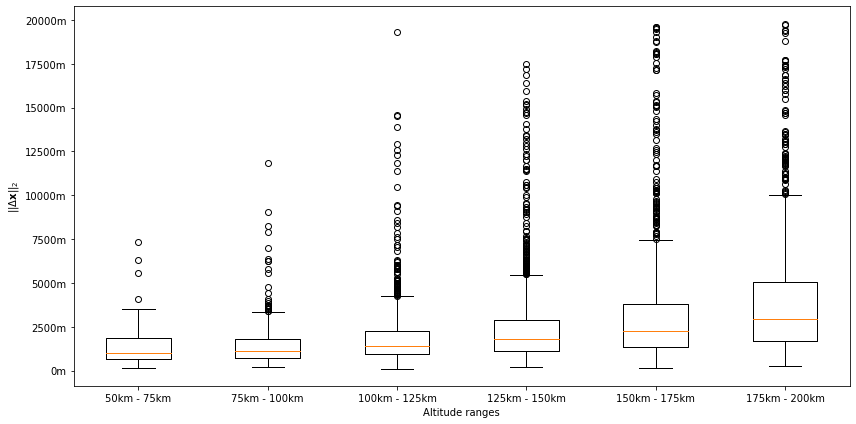

In [173]:
dist_filter = err_verified < 20e3
fig, ax = plt.subplots(figsize=(12, 6))
n = n_verified_test[verified_positions][dist_filter]
data = []
ticklabels = []
medians = []

height_levels = np.arange(50, 201, 25)

for h_min, h_max in zip(height_levels[:-1], height_levels[1:]):

    h = LA.norm(true_position_test[verified_positions][dist_filter], axis=(1,2))
    f = np.logical_and(h_min < (h - const.RMOON), (h-const.RMOON) < h_max)
    if f.sum() < 20:
        continue
    d = err_verified[dist_filter][f]
    medians.append(np.median(d))

    data.append(d)
    ticklabels.append(f"{h_min}km - {h_max}km")

ax.boxplot(data)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%im'))
ax.set_xticklabels(ticklabels)
ax.set_xlabel("Altitude ranges")
ax.set_ylabel("$||\Delta \mathbf{x}||_2$")
fig.tight_layout()
fig.savefig("../output/altitude_accuracy_boxplot.pdf")
print(medians)

In [ ]:
np.arange(80, 301, 20)